<a href="https://colab.research.google.com/github/MarioCastilloM/Modern-Portfolio-Theory/blob/main/Portfolio_Oprimization_a_Realistic_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Portfolio Optimization: A Realistic Approach**

This time we will extend the previous work about **MPT**: [Portfolio Optimization with MPT](https://github.com/MarioCastilloM/Modern-Portfolio-Theory) to a more realistic scenario where a portfolio has investments constraints established in its prospectus. In particular, we will assumme a portfolio with the following constraints:

- Domestic Fixed Income (USA): minimum 20% and maximum 60%
- Latin American Stocks: maximum 20%
- Domestic Stocks (USA): maximum 30%

Additionally, we will deploy a **Rebalancing Strategy** and finally use a **Monte Carlo Simulation**, both to face practical issues when trying to find the optimal portfolio.

First of all, we have to load the necessary libraries

In [ ]:
# !pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from dateutil.relativedelta import relativedelta
import datetime as dt
%matplotlib inline

Then, we will retrieve data from yahoo finance. As a proxy of Domestic Fixed Income we will use the **iShares 7-10 Year Treasury Bond ETF**, meanwhile as a proxy of Latin American Stocks we will use **iShares Latin America 40 ETF**. On the other hand, the Domestic Stocks selected are **Apple**, **Tesla** and **Amazon**. The assumed time horizon is 5 years. For the rest of the project until the optimization, we follow the same path of the previous post: [Portfolio Optimization with MPT](https://github.com/MarioCastilloM/Modern-Portfolio-Theory).

In [ ]:
fixed_income = ['IEF']  # iShares 7-10 Year Treasury Bond ETF (IEF)
latam_stocks = ['ILF']  # iShares Latin America 40 ETF (ILF)
usa_stocks = ['AAPL', 'TSLA', 'AMZN']  # USA Stocks

tickers = fixed_income + latam_stocks + usa_stocks

horizon = 5
end = dt.date.today()
start = end - relativedelta(years=horizon)

data = yf.download(tickers, start=start, end=end)['Adj Close']

data.dropna(inplace=True)

data.tail()

[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,IEF,ILF,TSLA
Date,,,,,
2024-09-25 00:00:00+00:00,226.369995,192.529999,97.784149,25.959999,257.019989
2024-09-26 00:00:00+00:00,227.520004,191.160004,97.714348,26.209999,254.220001
2024-09-27 00:00:00+00:00,227.789993,187.970001,98.103210,26.120001,260.459991
2024-09-30 00:00:00+00:00,233.000000,186.330002,97.834007,25.910000,261.630005
2024-10-01 00:00:00+00:00,226.210007,185.130005,98.190002,25.910000,258.019989


In [ ]:
returns = data.pct_change().dropna()

mean_daily_returns = returns.mean()
mean_annual_returns = mean_daily_returns * 252  # 252 trading days in a year

cov_daily = returns.cov()
cov_annual = cov_daily * 252

In [24]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return - (p_returns - risk_free_rate) / p_std

def portfolio_variance(weights, mean_returns, cov_matrix):
  return portfolio_performance(weights, mean_returns, cov_matrix)[1] ** 2

In [ ]:
asset_categories = {
    'Fixed Income': fixed_income,
    'LATAM Stocks': latam_stocks,
    'USA Stocks': usa_stocks
}

fixed_income_indices = [tickers.index(ticker) for ticker in fixed_income]
latam_indices = [tickers.index(ticker) for ticker in latam_stocks]
usa_indices = [tickers.index(ticker) for ticker in usa_stocks]

Here set all the initial weights equally, assumed the risk-free rate as 2% and settled the constraints:
- Sum of all weights equal to 1 (eq)
- ineq will allow us to set maximums, for example:
```
# 0.6 - sum of fixed income weights >= 0
```
ensures us don't invest more than 60% in fixed income.

In [ ]:
num_assets = len(tickers)
initial_weights = num_assets * [1. / num_assets,]

risk_free_rate = 0.02  # assuming a 2% risk-free rate

bounds = tuple((0, 1) for asset in range(num_assets))

constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
    {'type': 'ineq', 'fun': lambda x: np.sum([x[i] for i in fixed_income_indices]) - 0.2},  # Min 20% in Fixed Income
    {'type': 'ineq', 'fun': lambda x: 0.6 - np.sum([x[i] for i in fixed_income_indices])},  # Max 60% in Fixed Income
    {'type': 'ineq', 'fun': lambda x: 0.2 - np.sum([x[i] for i in latam_indices])},        # Max 20% in LATAM Stocks
    {'type': 'ineq', 'fun': lambda x: 0.3 - np.sum([x[i] for i in usa_indices])},          # Max 30% in USA Stocks
]

In [ ]:
optimized_sharpe = minimize(
    neg_sharpe_ratio,
    initial_weights,
    args=(mean_annual_returns, cov_annual, risk_free_rate),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights_sharpe = optimized_sharpe.x

max_sharpe_return, max_sharpe_std = portfolio_performance(optimal_weights_sharpe, mean_annual_returns, cov_annual)
max_sharpe_ratio = (max_sharpe_return - risk_free_rate) / max_sharpe_std

weights_df = pd.DataFrame({
    'Ticker': tickers,
    'Optimal Weights': optimal_weights_sharpe
})

weights_df

,Ticker,Optimal Weights
0,IEF,0.6
1,ILF,0.1
2,AAPL,0.0
3,TSLA,0.0
4,AMZN,0.3


## **Rebalancing**

Rebalancing is useful because it keeps your portfolio aligned with your investment goals and risk tolerance, promotes disciplined investing, and helps maintain diversification. By regularly adjusting your asset allocations, you manage risk more effectively and potentially enhance returns over time.

In [13]:
rebalancing_frequency = 252/2  # Semi-annual rebalancing

portfolio_values = [1]  # Start with $1 investment
dates = [returns.index[0]]
weights_history = [optimal_weights_sharpe]
current_weights = optimal_weights_sharpe.copy()

In [14]:
all_dates = returns.index

for i in range(1, len(all_dates)):
    date = all_dates[i]
    previous_date = all_dates[i - 1]
    daily_returns = returns.loc[date]

    # Update portfolio value
    portfolio_growth = np.sum(current_weights * daily_returns)
    new_portfolio_value = portfolio_values[-1] * (1 + portfolio_growth)
    portfolio_values.append(new_portfolio_value)
    dates.append(date)

    # Rebalance if needed
    if (i % rebalancing_frequency) == 0:
        weights_history.append(current_weights)

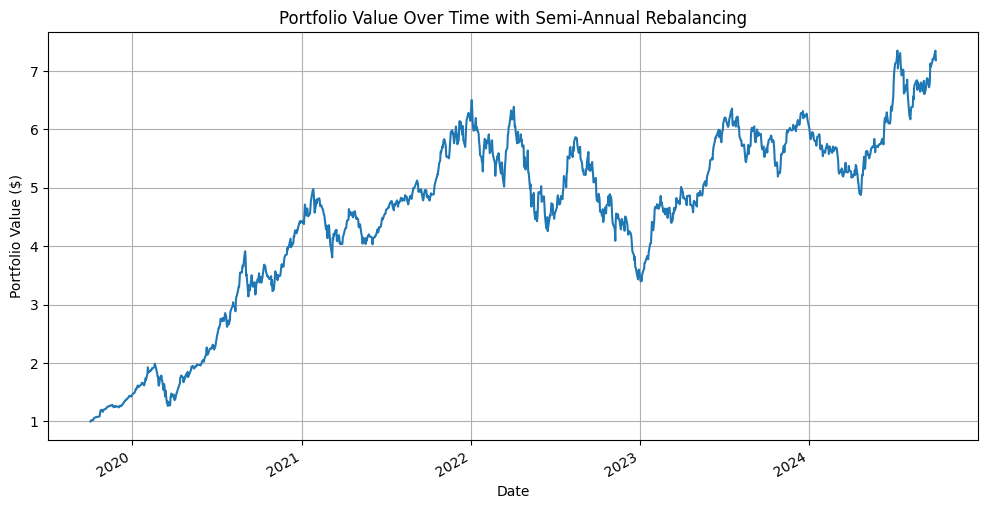

In [16]:
portfolio_df = pd.DataFrame({
    'Date': dates,
    'Portfolio Value': portfolio_values
}).set_index('Date')

plt.figure(figsize=(12, 6))
portfolio_df['Portfolio Value'].plot()
plt.title('Portfolio Value Over Time with Semi-Annual Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.show()

Observing the evolution of your portfolio's value with rebalancing applied provides concrete evidence of these benefits. It demonstrates how rebalancing can lead to a more stable and potentially more profitable investment journey, reinforcing the importance of sticking to your investment strategy despite market fluctuations.

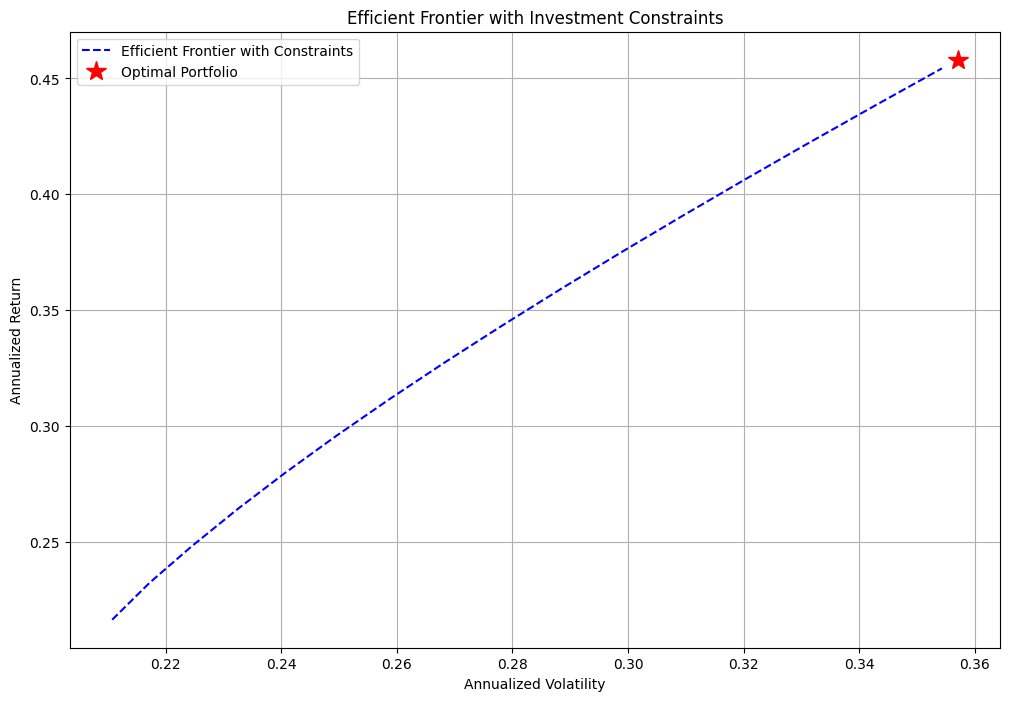

In [25]:
def efficient_frontier(mean_returns, cov_matrix, returns_range, constraints, bounds):
    efficient_portfolios = []
    for ret in returns_range:
        # Add the target return constraint
        cons = constraints + [{'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - ret}]
        # Minimize portfolio variance
        result = minimize(portfolio_variance, initial_weights, args=(mean_returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=cons)
        if result.success:
            p_returns, p_std = portfolio_performance(result.x, mean_returns, cov_matrix)
            efficient_portfolios.append({'Return': p_returns, 'Volatility': p_std})
    return efficient_portfolios

target_returns = np.linspace(mean_annual_returns.min(), mean_annual_returns.max(), 50)

efficient_portfolios = efficient_frontier(mean_annual_returns, cov_annual, target_returns, constraints, bounds)

frontier_returns = [p['Return'] for p in efficient_portfolios]
frontier_volatility = [p['Volatility'] for p in efficient_portfolios]

plt.figure(figsize=(12, 8))
plt.plot(frontier_volatility, frontier_returns, 'b--', label='Efficient Frontier with Constraints')
plt.plot(max_sharpe_std, max_sharpe_return, 'r*', markersize=15, label='Optimal Portfolio')
plt.title('Efficient Frontier with Investment Constraints')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

<Axes: >

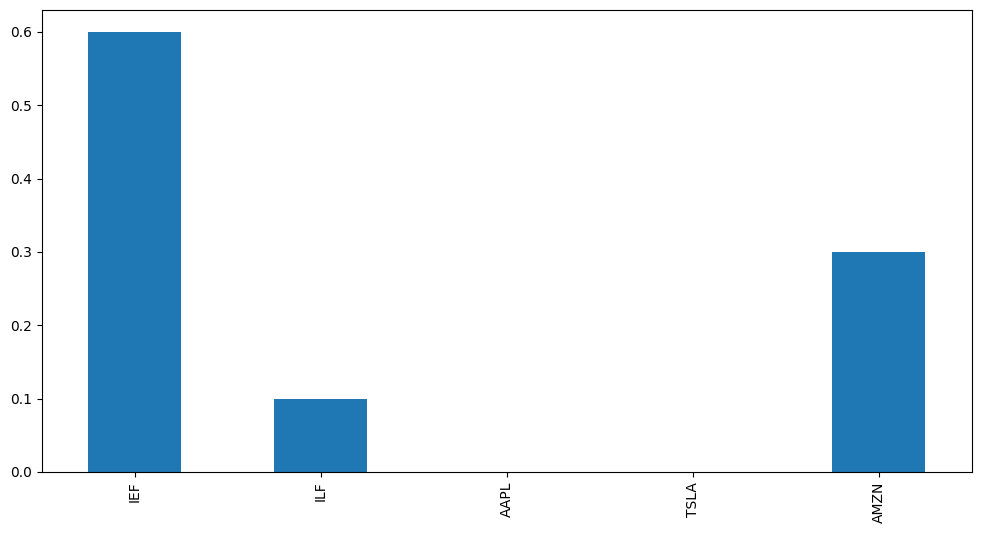

In [37]:
pd.Series(optimal_weights_sharpe, name='Optimal Weights', index=tickers).plot(kind='bar', figsize=(12, 6))

## **Monte Carlo Simulation**

Here we propose an alternative path to find the optimal portfolio through a Monte Carlo Simulation. Using a it to obtain the optimal portfolio is useful because it:

- Provides a flexible framework to model complex constraints and real-world factors.
- Offers a comprehensive view by simulating a wide range of possible portfolio outcomes.
- Enhances risk assessment by showing the distribution of potential returns and risks.
- Allows for empirical visualization of the efficient frontier and identification of optimal portfolios.
- Improves decision-making by incorporating uncertainty and variability into the analysis.

This approach is more practical and informative than relying solely on traditional optimization methods, as it captures the complexities and uncertainties inherent in financial markets, leading to more robust and realistic portfolio optimization.

In [29]:
num_portfolios = 10000

all_weights = []
ret_arr = []
vol_arr = []
sharpe_arr = []

risk_free_rate = 0.02  # 2%

for _ in range(num_portfolios):
    fixed_income_weight = np.random.uniform(0.2, 0.6)
    latam_weight = np.random.uniform(0, 0.2)
    usa_weight = np.random.uniform(0, 0.3)

    remaining_weight = 1 - (fixed_income_weight + latam_weight + usa_weight)

    if remaining_weight < 0:
        continue  # Skip if total exceeds 100%

    # Distribute remaining weight (if any) equally among other assets
    other_assets = []  # Adjust this list if you have other assets
    other_weights = []
    if other_assets:
        other_weight_per_asset = remaining_weight / len(other_assets)
        other_weights = [other_weight_per_asset] * len(other_assets)
    else:
        if remaining_weight > 0:
            # If there are no other assets, adjust the weights proportionally
            total_allocated = fixed_income_weight + latam_weight + usa_weight
            fixed_income_weight /= total_allocated
            latam_weight /= total_allocated
            usa_weight /= total_allocated

    # Allocate weights within each category to individual assets
    weights = np.zeros(len(tickers))

    # Fixed Income assets
    fixed_income_allocations = np.random.dirichlet(np.ones(len(fixed_income_indices)), size=1)[0]
    weights[fixed_income_indices] = fixed_income_allocations * fixed_income_weight

    # LATAM Stocks
    latam_allocations = np.random.dirichlet(np.ones(len(latam_indices)), size=1)[0]
    weights[latam_indices] = latam_allocations * latam_weight

    # USA Stocks
    usa_allocations = np.random.dirichlet(np.ones(len(usa_indices)), size=1)[0]
    weights[usa_indices] = usa_allocations * usa_weight

    # Other assets (if any)
    # weights[other_indices] = other_weights  # Uncomment and adjust if you have other assets

    # Ensure weights sum to 1
    total_weight = np.sum(weights)
    if not np.isclose(total_weight, 1):
        continue  # Skip if weights don't sum to 1

    # Save weights
    all_weights.append(weights)

    # Calculate portfolio return and volatility
    portfolio_return = np.sum(mean_annual_returns * weights)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))

    # Save metrics
    ret_arr.append(portfolio_return)
    vol_arr.append(portfolio_std)
    sharpe_arr.append((portfolio_return - risk_free_rate) / portfolio_std)

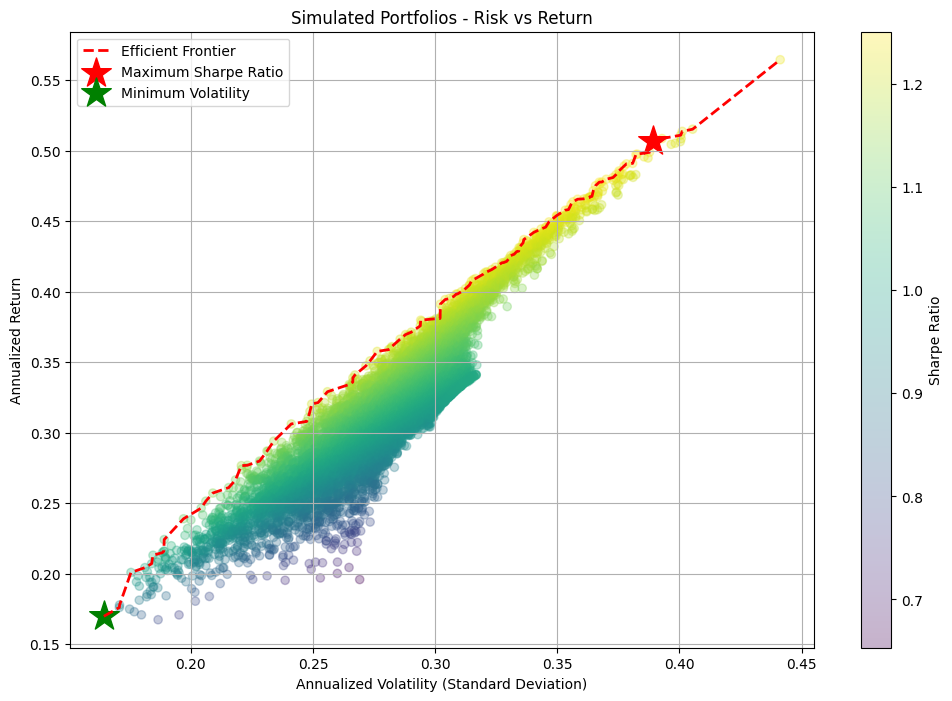

Maximum Sharpe Ratio Portfolio:
Return: 50.67%
Volatility: 38.91%
Sharpe Ratio: 1.25
Weights:
IEF     0.565795
ILF     0.001184
AAPL    0.021225
TSLA    0.006255
AMZN    0.405541
Name: 2024, dtype: float64

Minimum Volatility Portfolio:
Return: 16.97%
Volatility: 16.43%
Sharpe Ratio: 0.91
Weights:
IEF     0.464395
ILF     0.009743
AAPL    0.458985
TSLA    0.057964
AMZN    0.008913
Name: 4894, dtype: float64


In [31]:
portfolio_results = pd.DataFrame({
    'Return': ret_arr,
    'Volatility': vol_arr,
    'Sharpe Ratio': sharpe_arr
})

weights_df = pd.DataFrame(all_weights, columns=tickers)
portfolio_results = pd.concat([portfolio_results, weights_df], axis=1)

max_sharpe_idx = portfolio_results['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolio_results.loc[max_sharpe_idx]

min_vol_idx = portfolio_results['Volatility'].idxmin()
min_vol_portfolio = portfolio_results.loc[min_vol_idx]

portfolio_results = portfolio_results.sort_values(by='Volatility')

efficient_volatility = []
efficient_returns = []

# Initialize the minimum return to a very high number
prev_return = -np.inf

for index, row in portfolio_results.iterrows():
    if row['Return'] > prev_return:
        efficient_volatility.append(row['Volatility'])
        efficient_returns.append(row['Return'])
        prev_return = row['Return']

plt.figure(figsize=(12, 8))

plt.scatter(portfolio_results['Volatility'], portfolio_results['Return'],
            c=portfolio_results['Sharpe Ratio'], cmap='viridis', alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

plt.plot(efficient_volatility, efficient_returns, 'r--', linewidth=2, label='Efficient Frontier')

plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'],
            marker='*', color='red', s=500, label='Maximum Sharpe Ratio')

plt.scatter(min_vol_portfolio['Volatility'], min_vol_portfolio['Return'],
            marker='*', color='green', s=500, label='Minimum Volatility')

plt.title('Simulated Portfolios - Risk vs Return')
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

print("Maximum Sharpe Ratio Portfolio:")
print(f"Return: {max_sharpe_portfolio['Return']:.2%}")
print(f"Volatility: {max_sharpe_portfolio['Volatility']:.2%}")
print(f"Sharpe Ratio: {max_sharpe_portfolio['Sharpe Ratio']:.2f}")
print("Weights:")
print(max_sharpe_portfolio[tickers])

print("\nMinimum Volatility Portfolio:")
print(f"Return: {min_vol_portfolio['Return']:.2%}")
print(f"Volatility: {min_vol_portfolio['Volatility']:.2%}")
print(f"Sharpe Ratio: {min_vol_portfolio['Sharpe Ratio']:.2f}")
print("Weights:")
print(min_vol_portfolio[tickers])


<Axes: >

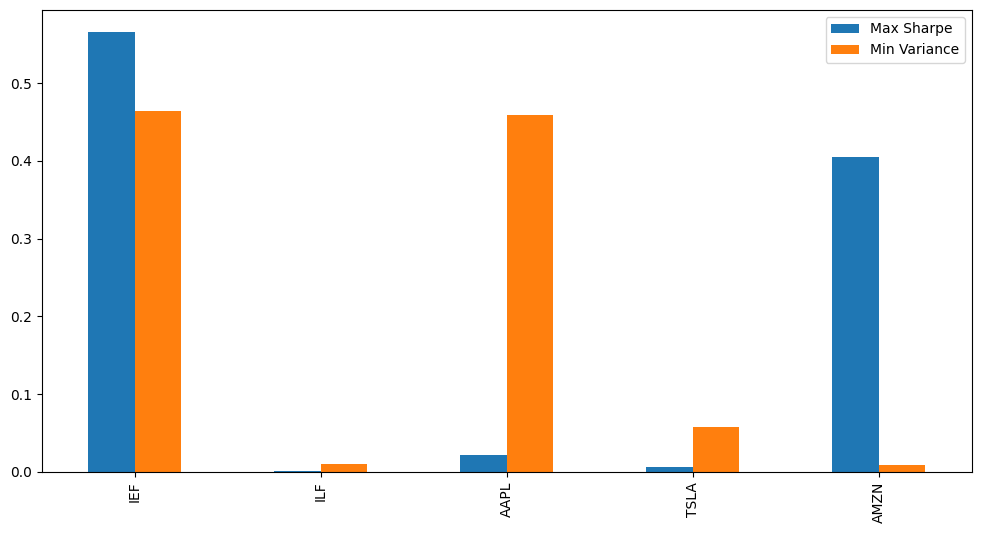

In [44]:
df_portfolios = pd.DataFrame({'Max Sharpe': max_sharpe_portfolio[tickers],
              'Min Variance': min_vol_portfolio[tickers]})
df_portfolios.plot(kind='bar', figsize=(12, 6))

## **Final Remarks**

**Conclusion**

In this project, we expanded upon the foundational principles of **MPT** to develop a more practical and realistic approach to portfolio optimization. By introducing real-world investment constraints—such as allocating between 20% to 60% in fixed income, up to 20% in LATAM stocks, and up to 30% in USA stocks—we tailored our model to reflect actual investment policies and risk considerations that investors face.

To further enhance the realism of our model, we implemented a **Monte Carlo simulation**. This allowed us to generate a vast number of potential portfolio combinations under the given constraints, providing a comprehensive view of possible outcomes. Through the simulation, we were able to empirically derive the efficient frontier, identify the optimal portfolio with the maximum Sharpe Ratio, and understand the distribution of returns and risks across different portfolio configurations. The Monte Carlo approach offered flexibility in handling complex constraints and capturing the uncertainties inherent in financial markets, which traditional analytical methods might overlook.

Additionally, we incorporated a **rebalancing strategy** into our analysis. Rebalancing ensures that the portfolio maintains its intended asset allocation over time, despite market fluctuations. By simulating the portfolio's performance with regular rebalancing, we observed a more stable growth trajectory and consistent adherence to our risk tolerance and investment objectives. Rebalancing not only helps in managing risk but also enforces a disciplined investment approach, potentially enhancing long-term returns.

This enhanced approach is more practical than basic MPT because it accounts for the complexities and limitations inherent in real-world investing. While traditional MPT assumes unrestricted asset allocation and static market conditions, our model accommodates investment constraints, market dynamics, and the need for ongoing portfolio management. By incorporating Monte Carlo simulation and rebalancing strategies, we ensure that the resulting portfolios are not only theoretically optimal but also robust and implementable in reality.

The value generated by this project lies in its applicability to real investment scenarios. It provides investors and portfolio managers with a flexible framework to construct and manage portfolios that aim for the best possible returns while adhering to specific investment guidelines and risk parameters. By bridging the gap between theoretical models and practical application, this project offers a valuable tool for making informed investment decisions that are both optimal and feasible in the real world.